# Introduction

This notebook compares the performance of a custom bulit network against pre-trained ResNet18 network for the task of classification of CIFAR10 dataset.

## Imports

In [1]:
## importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
use_cuda = torch.cuda.is_available()
device =torch.device('cuda' if use_cuda else 'cpu')
print(f"The device is: {device}")

The device is: cuda


## Load the Dataset

In [3]:
# Define transforms
transform_train =transforms.Compose([transforms.RandomVerticalFlip(),
                                     transforms.RandomRotation(120),
                                     transforms.RandomHorizontalFlip(45),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                    

In [4]:
# Create training set and define training and validation dataloader
train_set = torchvision.datasets.CIFAR10(root="/kaggle/working",train =True, transform = transform_train, download=True)

# split the train set into train and validation set
val_data, train_data = torch.utils.data.random_split(train_set, [1000, 49000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size =64, 
                                           shuffle =True, num_workers =2)
val_loader =  torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=True, num_workers=2)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root="/kaggle/working",train =False, transform = transform_test, download=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle =True, num_workers =2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working
Files already downloaded and verified


## Explore the Dataset

In [5]:
## Exploring the data
print(f"Training set has: {train_data.__len__()} samples")
print(f"Validation set has: {val_data.__len__()} samples")
print(f"Test set has: {test_data.__len__()} samples")


Training set has: 49000 samples
Validation set has: 1000 samples
Test set has: 10000 samples


In [6]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    print(f"Image shape : {np.shape(images[0].numpy())} \n")
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Image shape : (3, 32, 32) 

cat


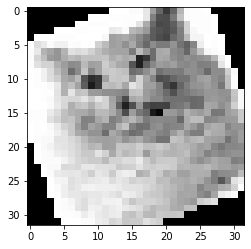

horse


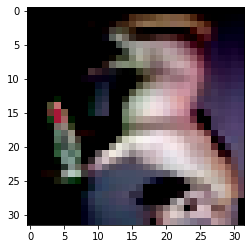

dog


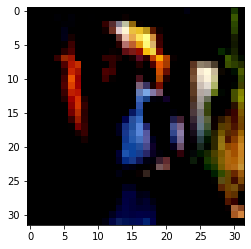

dog


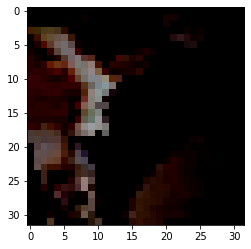

ship


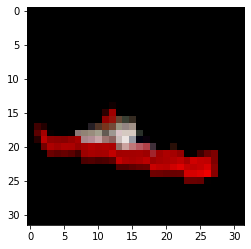

In [7]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
class mynet(nn.Module):
    def __init__(self):
        super(mynet, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, 3)       
        self.conv2 = nn.Conv2d(128, 256, 4)
        self.conv3 = nn.Conv2d(256, 512, 3)
        self.fc1 = nn.Linear(512 * 2 * 2, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,90)
        self.bn2 = nn.BatchNorm1d(90)
        self.fc3 = nn.Linear(90, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.fc4 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):

        #conv layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #conv layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #conv layer 3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #flatten
        x = x.reshape(-1, 2*2*512)
        #fc 1
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        #fc2
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.bn2(x)
        #fc3
        x = F.elu(self.fc3(x))
        x = self.dropout(x)
        x = self.bn3(x)
        #fc4
        x=self.fc4(x)      
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
model = mynet().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
def get_accuracy(pred, labels):
    total = 0
    correct = 0 
    labels , pred = labels.cpu() , pred.cpu()
    _,predicted = torch.max(pred , 1)
    total += len(labels.numpy())
    correct += ((predicted == labels).numpy()).sum()
    return correct/total

def validate(model, valoader, criterion):
    val_loss = 0
    val_accuracy = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
        
    return avg_loss, avg_acc
    
    
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

In [12]:
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val    = []
for epoch in range(30):
    train_loss,train_acc, model = train_one_epoch(model, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    message = print(f'{epoch} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

0 Train Loss: 1.9562 Train Acc: 0.2683 Val Loss: 1.8829 Val Acc: 0.3080
None
1 Train Loss: 1.7473 Train Acc: 0.3549 Val Loss: 1.6558 Val Acc: 0.3855
None
2 Train Loss: 1.7612 Train Acc: 0.3488 Val Loss: 2.0842 Val Acc: 0.2406
None
3 Train Loss: 1.6588 Train Acc: 0.3884 Val Loss: 1.5868 Val Acc: 0.4076
None
4 Train Loss: 1.6047 Train Acc: 0.4094 Val Loss: 1.6353 Val Acc: 0.3859
None
5 Train Loss: 1.5575 Train Acc: 0.4261 Val Loss: 1.4632 Val Acc: 0.4494
None
6 Train Loss: 1.5198 Train Acc: 0.4389 Val Loss: 1.4906 Val Acc: 0.4393
None
7 Train Loss: 1.4927 Train Acc: 0.4497 Val Loss: 1.6556 Val Acc: 0.3943
None
8 Train Loss: 1.4800 Train Acc: 0.4548 Val Loss: 1.3974 Val Acc: 0.4773
None
9 Train Loss: 1.4505 Train Acc: 0.4686 Val Loss: 1.3671 Val Acc: 0.4984
None
10 Train Loss: 1.4283 Train Acc: 0.4735 Val Loss: 1.4081 Val Acc: 0.4822
None
11 Train Loss: 1.4134 Train Acc: 0.4851 Val Loss: 1.3382 Val Acc: 0.5098
None
12 Train Loss: 1.3954 Train Acc: 0.4918 Val Loss: 1.3632 Val Acc: 0.4934
N

Plots

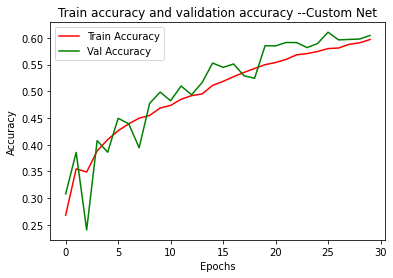

In [13]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,acc_train, 'r-',label='Train Accuracy')
plt.plot(epochs,acc_val, 'g-',label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train accuracy and validation accuracy --Custom Net")
plt.legend()

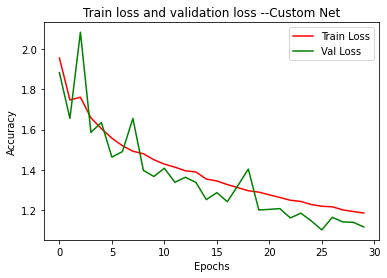

In [14]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,loss_train, 'r-',label='Train Loss')
plt.plot(epochs,loss_val, 'g-',label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train loss and validation loss --Custom Net" )
plt.legend()

## Testing the custom model

In [15]:
correct = 0 # number of correct predictions
total   = 0 # number of samples in test set

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels =images.to(device), labels.to(device)
        model.eval()
        outputs = model(images)
        _,predicted = torch.max(outputs.data , 1)
        total += labels.size(0)
        correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
print(f"accuracy of the network on test set:{100*correct/total}%")
        

accuracy of the network on test set:62.80408163265306%


## Transfer Learning for CIFAR10 with ResNet-18

### Try 1: finetuning the complete ResNet-18


In [16]:
resnet1 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
# modifying the fully connected layer 
fc_in = resnet1.fc.in_features
resnet1.fc = nn.Linear(fc_in, 10)

In [18]:
resnet1 = resnet1.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet1.parameters(), lr=1e-3)

In [20]:
## Training resnet18 on CIFAR 10
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val    = []
for epoch in range(30):
    train_loss,train_acc, model = train_one_epoch(resnet1, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(resnet1, val_loader, criterion)
    
    message = print(f'{epoch} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

0 Train Loss: 1.5515 Train Acc: 0.4425 Val Loss: 1.4000 Val Acc: 0.5164
None
1 Train Loss: 1.2924 Train Acc: 0.5487 Val Loss: 1.2951 Val Acc: 0.5557
None
2 Train Loss: 1.1978 Train Acc: 0.5823 Val Loss: 1.3009 Val Acc: 0.5518
None
3 Train Loss: 1.1295 Train Acc: 0.6037 Val Loss: 1.1867 Val Acc: 0.5701
None
4 Train Loss: 1.0729 Train Acc: 0.6233 Val Loss: 1.1076 Val Acc: 0.6412
None
5 Train Loss: 1.0242 Train Acc: 0.6434 Val Loss: 1.0702 Val Acc: 0.6139
None
6 Train Loss: 1.0005 Train Acc: 0.6501 Val Loss: 1.0571 Val Acc: 0.6443
None
7 Train Loss: 0.9850 Train Acc: 0.6580 Val Loss: 1.0355 Val Acc: 0.6316
None
8 Train Loss: 0.9834 Train Acc: 0.6587 Val Loss: 1.0049 Val Acc: 0.6541
None
9 Train Loss: 0.9369 Train Acc: 0.6752 Val Loss: 0.9991 Val Acc: 0.6465
None
10 Train Loss: 0.9231 Train Acc: 0.6762 Val Loss: 0.9470 Val Acc: 0.6711
None
11 Train Loss: 0.8789 Train Acc: 0.6940 Val Loss: 0.9636 Val Acc: 0.6703
None
12 Train Loss: 0.8838 Train Acc: 0.6933 Val Loss: 0.9475 Val Acc: 0.6633
N

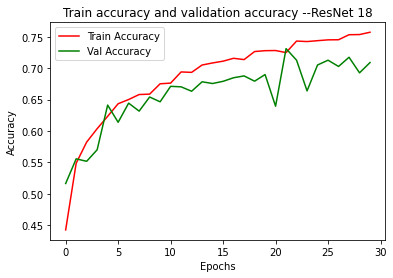

In [21]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,acc_train, 'r-',label='Train Accuracy')
plt.plot(epochs,acc_val, 'g-',label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train accuracy and validation accuracy --ResNet 18")
plt.legend()

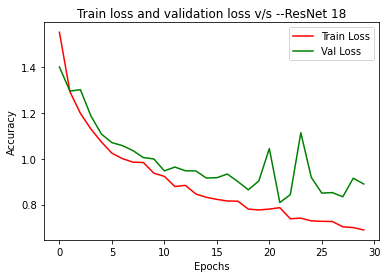

In [22]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,loss_train, 'r-',label='Train Loss')
plt.plot(epochs,loss_val, 'g-',label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train loss and validation loss v/s --ResNet 18")
plt.legend()

In [23]:
correct = 0 # number of correct predictions
total   = 0 # number of samples in test set

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels =images.to(device), labels.to(device)
        model.eval()
        outputs = resnet1(images)
        _,predicted = torch.max(outputs.data , 1)
        total += labels.size(0)
        correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
print(f"accuracy of the network on test set:{100*correct/total}%")

accuracy of the network on test set:77.85102040816327%


### Try 2: Freezing the Convnet weights
- ResNet18 trained on Imagenet will be used.
- Only the fully connected layer will be trained, by freezing the weights for all other layers.

In [24]:
# importing resnet18 from torchvision with pretrained weights
resnet = torchvision.models.resnet18(pretrained=True)



In [25]:
# freezing weights in all the layers
for param in resnet.parameters():
    param.requires_grad = False

# modifying the fully connected layer 
fc_in = resnet.fc.in_features
resnet.fc = nn.Linear(fc_in, 10)

In [26]:
resnet = resnet.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

In [28]:
## Training resnet18 on CIFAR 10
epochs     = []
loss_train = []
acc_train  = []
loss_val   = []
acc_val    = []
for epoch in range(30):
    train_loss,train_acc, model = train_one_epoch(resnet, train_loader,
                                        optimizer, criterion)
    val_loss, val_acc = validate(resnet, val_loader, criterion)
    
    message = print(f'{epoch} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    print(message)
    
    epochs.append(epoch)
    loss_train.append(train_loss)
    loss_val.append(val_loss)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

0 Train Loss: 1.9663 Train Acc: 0.2958 Val Loss: 1.8987 Val Acc: 0.3354
None
1 Train Loss: 1.8766 Train Acc: 0.3317 Val Loss: 1.8657 Val Acc: 0.3363
None
2 Train Loss: 1.8644 Train Acc: 0.3386 Val Loss: 1.8101 Val Acc: 0.3605
None
3 Train Loss: 1.8465 Train Acc: 0.3421 Val Loss: 1.9020 Val Acc: 0.3518
None
4 Train Loss: 1.8517 Train Acc: 0.3441 Val Loss: 1.8263 Val Acc: 0.3654
None
5 Train Loss: 1.8523 Train Acc: 0.3401 Val Loss: 1.8241 Val Acc: 0.3373
None
6 Train Loss: 1.8473 Train Acc: 0.3459 Val Loss: 1.8191 Val Acc: 0.3584
None
7 Train Loss: 1.8503 Train Acc: 0.3444 Val Loss: 1.8657 Val Acc: 0.3607
None
8 Train Loss: 1.8475 Train Acc: 0.3450 Val Loss: 1.8500 Val Acc: 0.3645
None
9 Train Loss: 1.8467 Train Acc: 0.3445 Val Loss: 1.8430 Val Acc: 0.3393
None
10 Train Loss: 1.8471 Train Acc: 0.3442 Val Loss: 1.8664 Val Acc: 0.3328
None
11 Train Loss: 1.8445 Train Acc: 0.3445 Val Loss: 1.8245 Val Acc: 0.3715
None
12 Train Loss: 1.8483 Train Acc: 0.3444 Val Loss: 1.8085 Val Acc: 0.3604
N

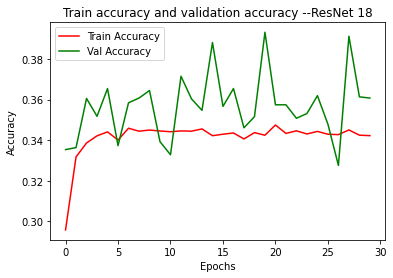

In [29]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,acc_train, 'r-',label='Train Accuracy')
plt.plot(epochs,acc_val, 'g-',label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train accuracy and validation accuracy --ResNet 18")
plt.legend()

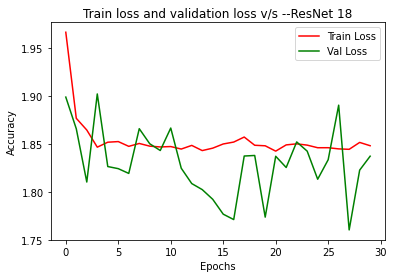

In [30]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,loss_train, 'r-',label='Train Loss')
plt.plot(epochs,loss_val, 'g-',label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train loss and validation loss v/s --ResNet 18")
plt.legend()

In [31]:
correct = 0 # number of correct predictions
total   = 0 # number of samples in test set

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels =images.to(device), labels.to(device)
        model.eval()
        outputs = resnet(images)
        _,predicted = torch.max(outputs.data , 1)
        total += labels.size(0)
        correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
print(f"accuracy of the network on test set:{100*correct/total}%")
        

accuracy of the network on test set:36.63469387755102%
